In [1]:
!pip install -r "../requirements.txt"


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
from fl.preprocessing import load_mnist, data_to_client
from fl.model import NN, train_and_test
from fl.utils import plot_train_and_test, weights_to_json
from fl.federated_learning import federated

2024-04-29 14:14:08.811624: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-29 14:14:08.814428: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-29 14:14:08.858695: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 14:14:09.679013: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Challenge 1 : Du poison [1/2]

Ces deux challenges visent à présenter la technique de *federated learning*, ainsi que les potentiels dangers à prendre en compte.

![du_poison.jpg](https://i.imgflip.com/8nfipd.jpg)

*Cette suite de challenges est accompagnée de fonctions utilitaires du module `fl`. Tout est dans le `.zip` donné en énoncé.*

## L'apprentissage fédéré

Parfois, au lieu de faire tout l'entraînement d'un coup depuis une unique base de donnée, l'on préfère entraîner **plusieurs versions du modèle** sur des données variées et potentiellement décentralisées. C'est le cas par exemple des algorithmes de recommandation qui vont s'entraîner directement sur les machines des utilisateurs, pour ensuite **s'agréger dans un serveur commun.**

### Exemple d'application dans laquelle on se place
Le serveur central créé un modèle de base, il enregistre ses poids et les envoie à tous les clients (les poids de base sont disponibles ici : `weights/base_fl.weights.h5`). Dans notre cas, il y a cinq clients, et vous êtes un des cinq clients. Chaque client entraîne le modèle de son côté, avec ses propres données (représentées dans notre simulation par `x_clients, y_clients`), puis envoie ses résultats, les poids, au serveur. Le serveur s'occupe alors d'agréger les poids en faisant une moyenne sur tous les clients. Il produit ainsi une nouvelle version du modèle commun, qu'il va pouvoir redistribuer et ainsi de suite. 

Imaginons que le modèle de base possède les poids : 
$$
M_1 = \{W_1, b_1, W_2, b_2, W_3, b_3, W_4, b_4\}
$$
*(ici, j'ai pris les notations couramment utilisées, $W$ pour *weights* et $b$ pour *biases*, tout est considéré comme un "poids" quand on code)*

Ensuite, chaque client entraîne le modèle sur son propre jeu de donnée, ce qui va faire évoluer les poids locaux : 
$$
i \in \llbracket1, \text{nb_client}\rrbracket, \quad M_1^{(i)} = \{W_1 + \delta W_1^{(i)}, b_1 + \delta b_1^{(i)}, W_2 + \delta W_2^{(i)}, b_2 + \delta b_2^{(i)}, W_3 + \delta W_3^{(i)}, b_3 + \delta b_3^{(i)}, W_4 + \delta W_4^{(i)}, b_4 + \delta b_4^{(i)}\} = \{W_1^{(i)}, b_1^{(i)}, W_2^{(i)}, b_2^{(i)}, W_3^{(i)}, b_3^{(i)}, W_4^{(i)}, b_4^{(i)}\}
$$

Les clients envoient leurs poids au serveur qui les agrège pour faire une nouvelle version du modèle commun : 
$$
M_2 = \left\{\sum_{i=1}^{\text{nb_clients}} W_1^{(i)}, \sum_{i=1}^{\text{nb_clients}} b_1^{(i)}, \sum_{i=1}^{\text{nb_clients}} W_2^{(i)}, \sum_{i=1}^{\text{nb_clients}} b_2^{(i)}, \sum_{i=1}^{\text{nb_clients}} W_3^{(i)}, \sum_{i=1}^{\text{nb_clients}} b_3^{(i)}, \sum_{i=1}^{\text{nb_clients}} W_4^{(i)}, \sum_{i=1}^{\text{nb_clients}} b_4^{(i)}\right\}
$$
et ainsi de suite.

Pour visualiser tout ça et pour potentiellement faire vos tests, je vous ai donné la fonction **coté serveur** qui s'occupe d'agréger les poids. C'est `federated`, et en fait, elle fait toute la simulation. Elle entraîne les cinq clients de leurs côtés puis agrège leurs poids. Voici un exemple : 

On commence d'abord par récupérer les données : 

In [3]:
fl_iterations = 5
client_epochs = 1
nb_clients = 5

x_train, y_train, x_test, y_test = load_mnist()
x_clients, y_clients = data_to_client(x_train, y_train, nb_clients=nb_clients)      # Simule le fait que les clients ont des jeux de données différents 

Tout le processus de l'apprentissage fédéré est contenu dans la fonction `federated` : 

In [4]:
federated_learning = federated(
    x_clients, 
    y_clients, 
    x_test,                             # Le serveur valide les résultats sur un seul et même jeu de test
    y_test, 
    fl_iterations=fl_iterations,        # On ne simule qu'une itération de l'apprentissage fédéré (M_1 -> M_2). 
    client_epochs=client_epochs                 
)

/home/sckathach/Desktop/404CTF-Intelligence-artificielle/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-04-29 14:14:10.896958: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-29 14:14:10.897350: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/

Federated learning iteration: 1
Client 0:
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Client 1:
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Client 2:
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Client 3:
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Client 4:
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Federated Accuracy: 0.118
Federated learning iteration: 2
Client 0:
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Client 1:
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Client 2:
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Client 3:
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Client 4:
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Federated Accuracy: 0.819
Federated learning iteration: 3
Client 0:
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Client 1:
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Client 2:
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Client 3:
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Client 4:
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


On peut ensuite afficher les résultats :

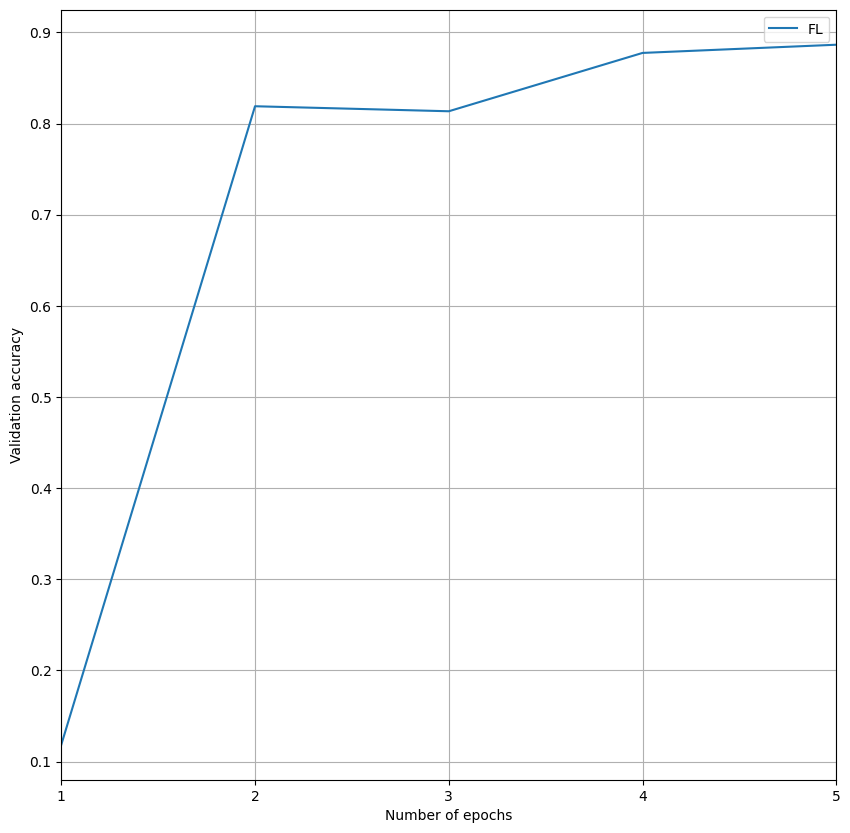

In [5]:
history = federated_learning["history_acc"]
plot_train_and_test([history], ["FL"], fl_iterations)

## De votre côté

De votre côté, vous n'avez pas besoin de simuler les 4 autres clients, vous n'avez qu'à vous occuper de votre version du modèle commun. 

Tout d'abord, il faut récupérer les poids et reprendre la structure du modèle commun $\left(W_1, b_1, W_2, b_2, W_3, b_3\right)$ : 

In [6]:
model_base = NN()
model_base.load_weights("../weights/base_fl.weights.h5")

/home/sckathach/Desktop/404CTF-Intelligence-artificielle/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Ensuite, on peut améliorer le modèle localement : 

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy of the model: 0.942


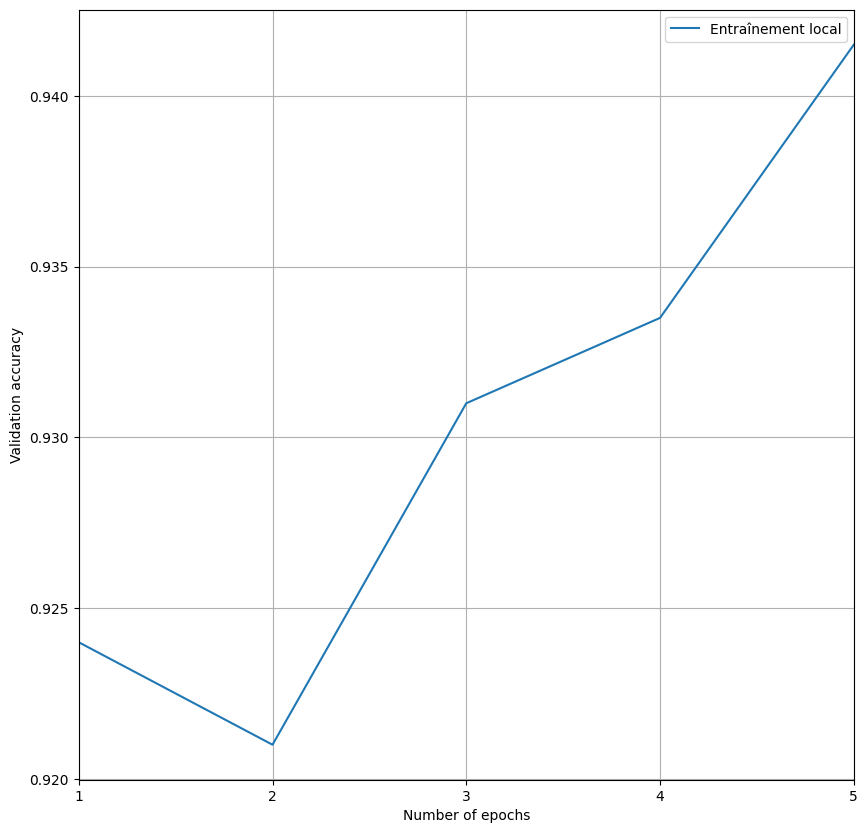

In [7]:
local_epochs = 5

local_results = train_and_test(
    model_base, 
    x_train,        # Vous pouvez entraîner votre modèle local sur toutes les données, sur ce que vous souhaitez en fait, c'est justement le principe.  
    y_train, 
    x_test, 
    y_test, 
    epochs=local_epochs
)
plot_train_and_test([local_results["history"].history["val_accuracy"]], ["Entraînement local"], epochs=local_epochs)

Votre modèle local entraîné est disponible ici : 

In [8]:
type(local_results["model"])

fl.model.NN

Et ses poids sont directement disponibles ici : 

In [9]:
print(f"""
Nombre de couches : {len(local_results["weights"])}
Taille de W1 : {local_results["weights"][0].shape}
Taille de b1 : {local_results["weights"][1].shape}
Taille de W2 : {local_results["weights"][2].shape}
Taille de b2 : {local_results["weights"][3].shape}
Taille de W3 : {local_results["weights"][4].shape}
Taille de b3 : {local_results["weights"][5].shape}
Taille de W4 : {local_results["weights"][6].shape}
Taille de b4 : {local_results["weights"][7].shape}
""")


Nombre de couches : 8
Taille de W1 : (784, 1000)
Taille de b1 : (1000,)
Taille de W2 : (1000, 700)
Taille de b2 : (700,)
Taille de W3 : (700, 500)
Taille de b3 : (500,)
Taille de W4 : (500, 10)
Taille de b4 : (10,)


Il vous suffit alors de renvoyer vos poids au serveur : 

In [10]:
import requests as rq

URL = "https://du-poison.challenges.404ctf.fr"
rq.get(URL + "/healthcheck").json()

{'message': 'Statut : en pleine forme !'}

In [11]:
d = weights_to_json(local_results["weights"])
# d = weights_to_json(model.get_weights())
rq.post(URL + "/challenges/1", json=d).json()

{'message': "Raté ! Le score de l'apprentissage fédéré est de 0.946. Il faut l'empoisonner pour qu'il passe en dessous de 0.5"}

## À vous de jouer !

Vous représentez **un client sur 5**, trouvez un moyen d'empoisonner le modèle pour faire descendre la précision au plus bas ! 

La structure du modèle doit rester la même, et vous n'avez pas accès aux paramètres `epochs, fl_iterations` codés directement coté serveur, il vous faut donc agir directement sur votre seul champ d'action : les poids ! 